In [18]:
# All hail Gemini!

In [19]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
results_id = '20250822_121724'
results_path = f'./results_analysis/results_{results_id}'

In [27]:
# Rename the top features rows

def transform_top_features(row):
    feature_string = row['top_features']
    method = row['method']

    if not isinstance(feature_string, str):
        return feature_string

    new_features = []
    for feature in feature_string.split(';'):
        if ':' not in feature:
            new_features.append(feature)
            continue

        name, value = feature.split(':', 1)
        name = name.replace('blocks.', '')
        parts = name.split('.')
        location = parts[0]
        component = ".".join(parts[1:])

        if 'resid' in component:
            new_component = 'residual'
        elif 'mlp' in component or 'ln2' in component:
            new_component = 'mlp'
        elif 'attn' in component or 'ln1' in component:
            new_component = 'attention'
        else:
            new_component = component
        
        # Keep the value for specific methods
        if method in ['diff', 'Component Similarities']:
            new_features.append(f"{location.strip()}.{new_component.strip()}:{value}")
        else:
            new_features.append(f"{location.strip()}.{new_component.strip()}")

    return ';'.join(new_features)

df_original = pd.read_csv(os.path.join(results_path, 'summary_all.csv'))
df_original['top_features'] = df_original.apply(transform_top_features, axis=1)

# corrected_filename = 'summary_all_renamed.csv'
# df_original.to_csv(corrected_filename, index=False)
# print(f"Correctly processed file saved as: {corrected_filename}")
# print("\nFirst 5 rows of a 'diff' method entry:")
# print(df_original[df_original['method'] == 'diff']['top_features'].head(1).values[0])

In [28]:
# Split to files according to model and method
models = df_original['model'].unique()
methods = df_original['method'].unique()

output_dir = os.path.join(results_path, 'split_files')
os.makedirs(output_dir)

for model in models:
    for method in methods:
        filtered_df = df_original[(df_original['model'] == model) & (df_original['method'] == method)]

        if not filtered_df.empty:
            filename = os.path.join(output_dir, f"{model}_{method}.csv")
            filtered_df.to_csv(filename, index=False)
            print(f"Created file: {filename}")

Created file: ./results_analysis/results_20250822_121724\split_files\gemma_lars.csv
Created file: ./results_analysis/results_20250822_121724\split_files\gemma_diff.csv
Created file: ./results_analysis/results_20250822_121724\split_files\gemma_Component Similarities.csv
Created file: ./results_analysis/results_20250822_121724\split_files\gemma2_lars.csv
Created file: ./results_analysis/results_20250822_121724\split_files\gemma2_diff.csv
Created file: ./results_analysis/results_20250822_121724\split_files\gemma2_Component Similarities.csv


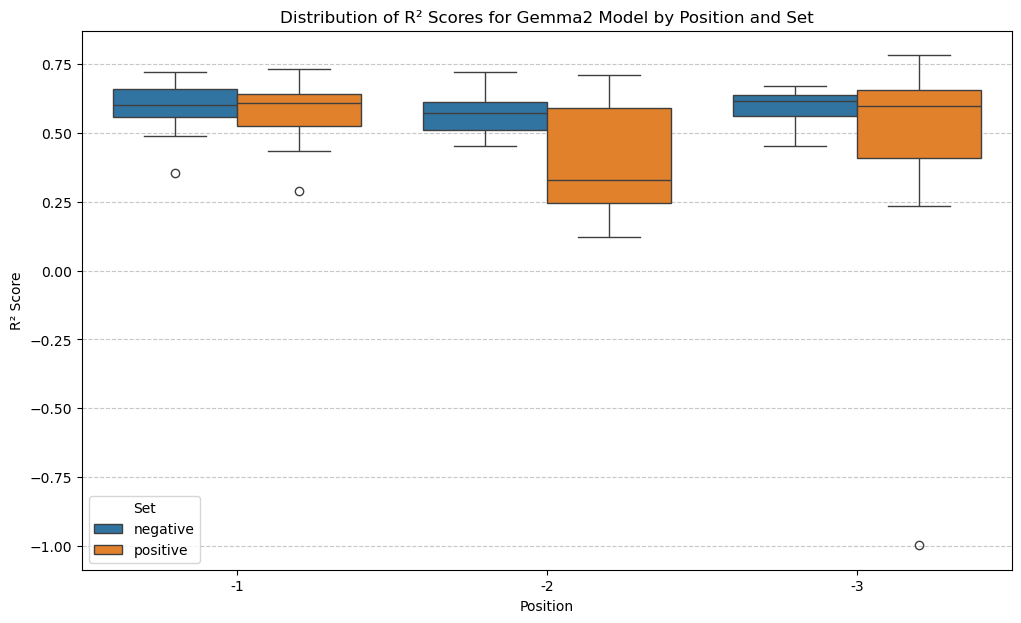

In [29]:
file_path = os.path.join(results_path, 'split_files/gemma2_lars.csv')
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df,
    x='position',
    y='r2',
    hue='set',
    order=[-1, -2, -3]
)

plt.title('Distribution of R² Scores for Gemma2 Model by Position and Set')
plt.xlabel('Position')
plt.ylabel('R² Score')
plt.legend(title='Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

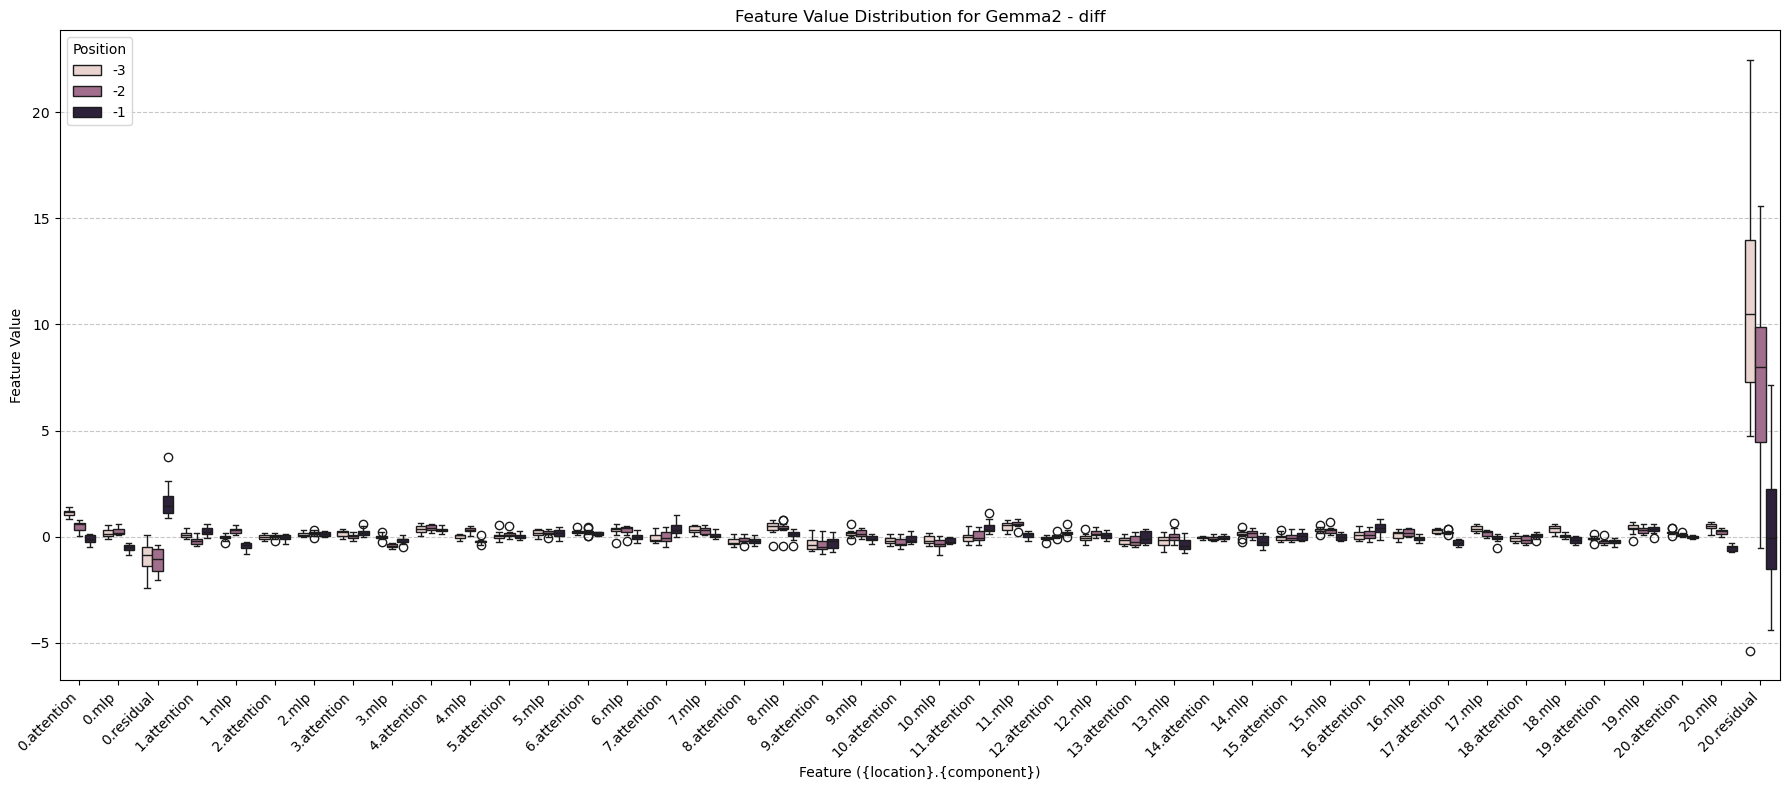

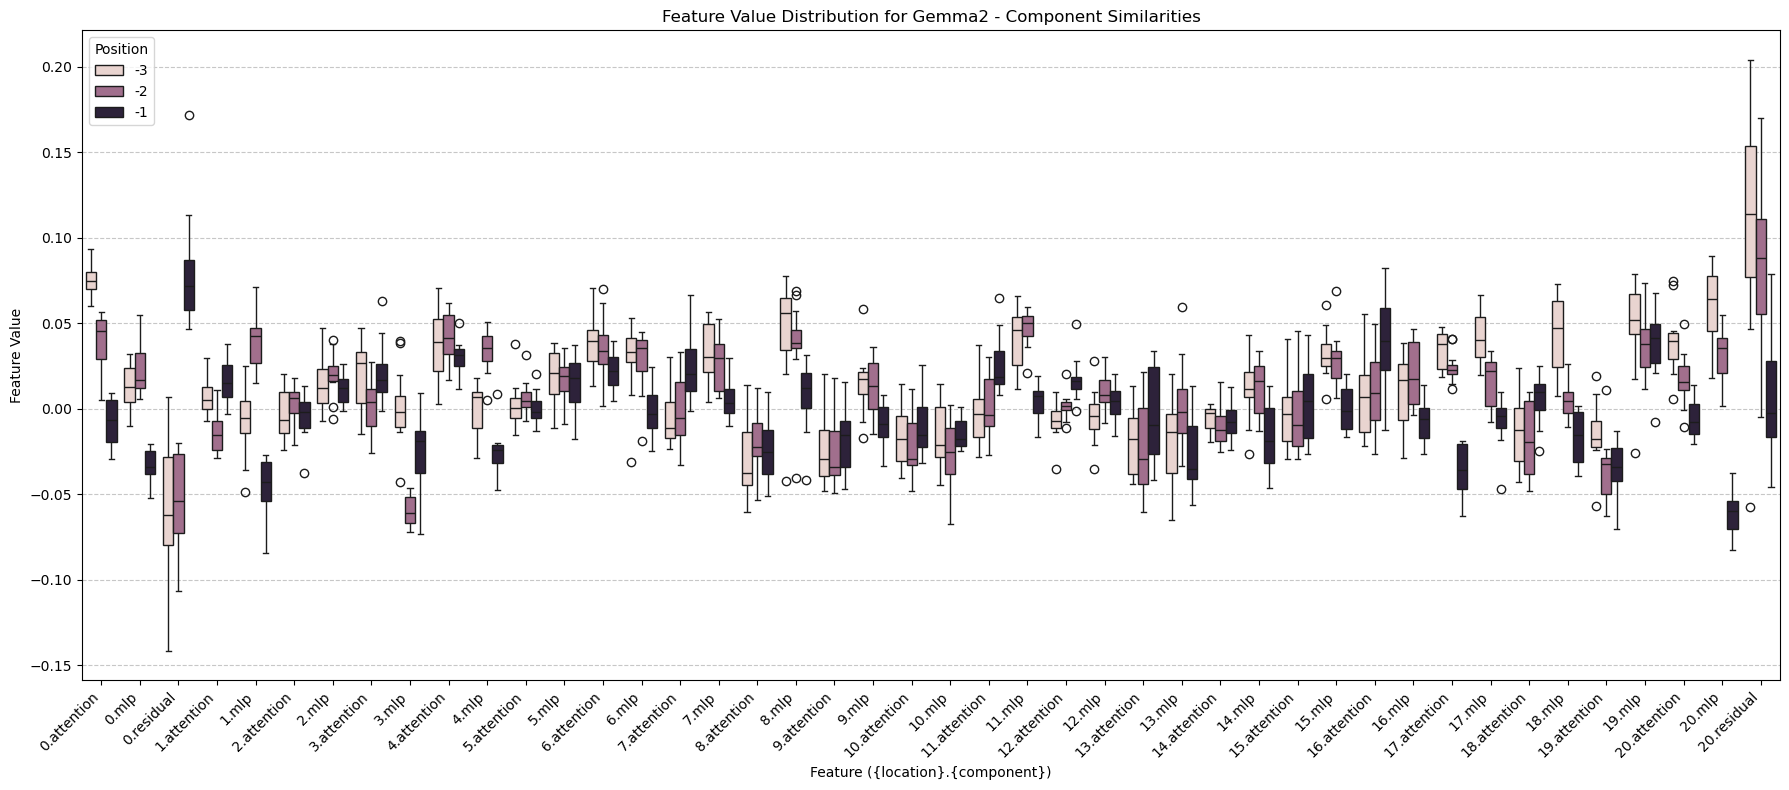

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

files_to_plot = [
    # os.path.join(results_path, 'split_files/gemma_diff.csv'),
    os.path.join(results_path, 'split_files/gemma2_diff.csv'),
    # os.path.join(results_path, 'split_files/gemma_Component Similarities.csv'),
    os.path.join(results_path, 'split_files/gemma2_Component Similarities.csv')
]

for file_path in files_to_plot:
    df = pd.read_csv(file_path)
    model_name, method_name = os.path.basename(file_path).replace('.csv', '').split('_', 1)

    def get_feature_set(feature_string):
        if not isinstance(feature_string, str): return set()
        return {f.split(':', 1)[0] for f in feature_string.split(';') if ':' in f}

    if df.empty: continue
    
    first_feature_set = get_feature_set(df['top_features'].iloc[0])
    for i in range(1, len(df)):
        current_feature_set = get_feature_set(df['top_features'].iloc[i])
        if first_feature_set != current_feature_set:
            print(first_feature_set ^ current_feature_set)
            raise ValueError(f"Feature sets are not consistent in {file_path}.")
                             
    long_data = []
    for _, row in df.iterrows():
        for feature in row['top_features'].split(';'):
            if ':' in feature:
                name, value = feature.split(':', 1)
                long_data.append({
                    'position': row['position'],
                    'feature_name': name,
                    'feature_value': float(value)
                })
    
    df_long = pd.DataFrame(long_data)
    
    def sort_key(feature_name):
        parts = feature_name.split('.')
        return (int(parts[0]), parts[1])

    sorted_features = sorted(df_long['feature_name'].unique(), key=sort_key)

    plt.figure(figsize=(18, 8))
    sns.boxplot(
        data=df_long, x='feature_name', y='feature_value',
        hue='position', order=sorted_features, hue_order=[-1, -2, -3]
    )

    plt.title(f'Feature Value Distribution for {model_name.capitalize()} - {method_name.replace("_", " ")}')
    plt.xlabel('Feature ({location}.{component})')
    plt.ylabel('Feature Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Position')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()